In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pickle
from spectres import spectres
from scipy.constants import c as speed_of_light
from tqdm import tqdm
import prodimopy.read as pread
from numba import njit
from scipy.stats import kendalltau, spearmanr, pearsonr

In [10]:
def total_flux(wl, flux_nu):
    """
    Calculate the total flux over the wavelengths and returns the flux in erg cm^-2 s^-1
    """
    flux_lambda = (speed_of_light * 100 / ((wl * 1e-4) ** 2)) * flux_nu * 1e-23
    tot_flux = np.trapezoid(flux_lambda, (wl * 1e-4))
    return tot_flux

In [11]:
with open('FLiTsData100.pkl', 'rb') as f:
    df = pickle.load(f)

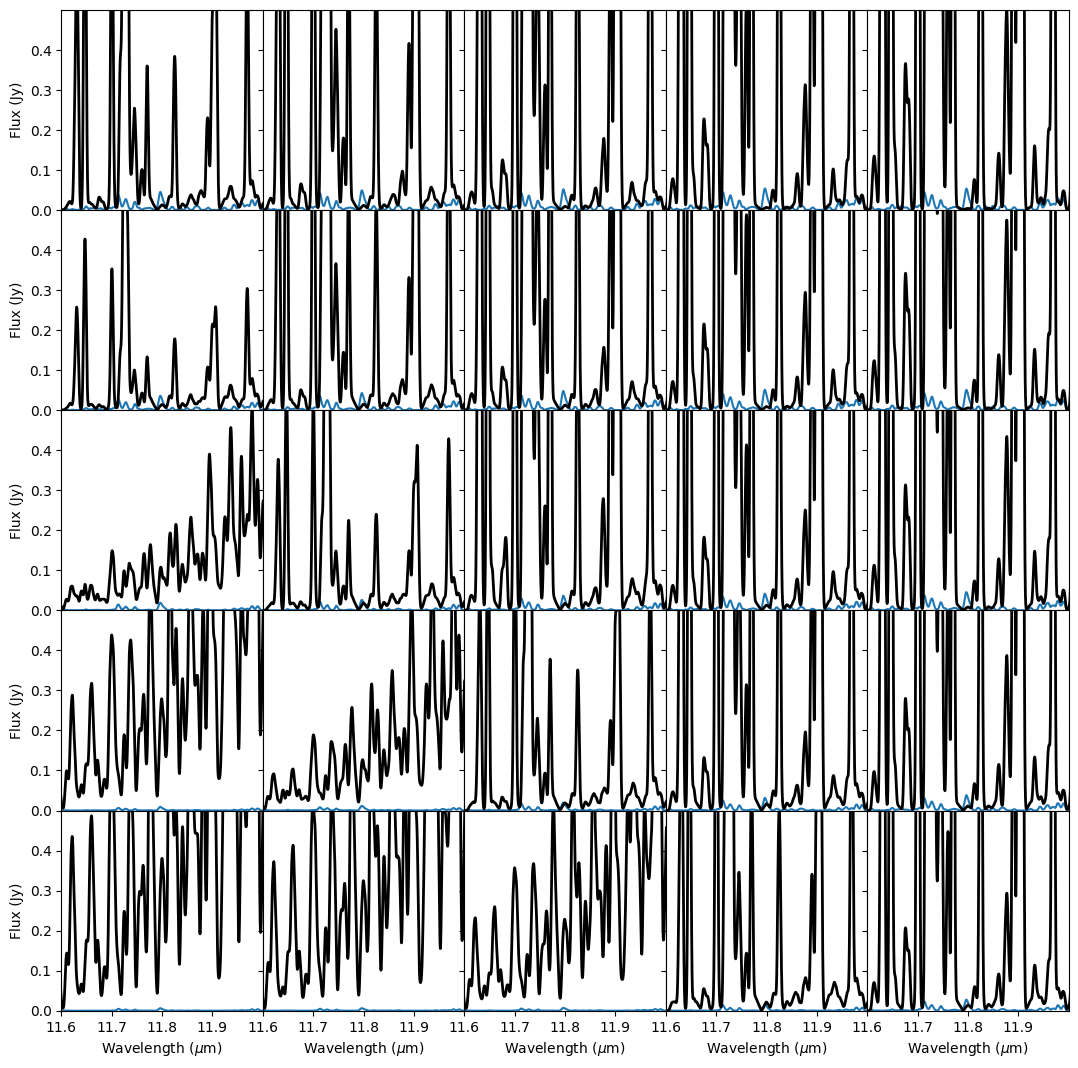

In [56]:
# %matplotlib notebook
plt.close('all')
total_spec = None
cmap = mpl.colormaps.get_cmap('tab20')
# fig, ax = plt.subplots(figsize=(14, 5))
species = ['C2H2','CH4', 'CO', 'CO2', 'H2O', 'HCN',  'NO', 'O2', 'OH','NH3']
# species = ['atomic', 'CH4',  'CO', 'CO2', 'HCN', 'NH3', 'NO', 'O2', 'OH']
species =['NH3']
fig = plt.figure(figsize=(13, 13))
gs = fig.add_gridspec(5, 5, hspace=0, wspace=0)
axes = gs.subplots(sharex='col', sharey='row').flatten()
xrange=[11.6, 12]
yrange=[0,.5]
num_xticks = 5
num_yticks = 6
for i in range(25):
    n_row, n_col = divmod(i, 5)
    total_spec = None
    # fig, ax = plt.subplots(figsize=(14, 5))
    model = df['Model Name'][i]
    FLiTs_wl = df.loc[df['Model Name'] == model, 'FLiTs Wavelength'].values[0].copy()
    FLiTs_flux = df.loc[df['Model Name'] == model, 'FLiTs Flux'].values[0].copy()
    for index, specie in enumerate(species):
        specie_wl = df.loc[df['Model Name'] == model, f'FLiTs {specie} Wavelength'].values[0].copy()
        specie_flux = df.loc[df['Model Name'] == model, f'FLiTs {specie} Flux'].values[0].copy()
        new_specie_flux = np.interp(FLiTs_wl, specie_wl, specie_flux, left=0, right=0)
        # if total_spec is None:
        #     total_spec = new_specie_flux
        # else:
        #     total_spec += new_specie_flux
        # axes[i].fill_between(FLiTs_wl, 0, total_spec*1000, label=specie, zorder=len(species) - index+1,
        #                 color=cmap(index / len(species)))
        # ax.fill_between(specie_wl,0, specie_flux*1000, label=specie, zorder=len(species) - index+1,
        #                 color=cmap(index / len(species)))
        # new_flux = np.interp(FLiTs_wl, specie_wl, specie_flux)
        # ax.plot(FLiTs_wl, np.log10(new_flux/FLiTs_flux+1))
        axes[i].plot(FLiTs_wl, new_specie_flux*1000)
    axes[i].plot(FLiTs_wl, FLiTs_flux*1000, c='black', lw=2, label='FLiTs', zorder=20)
    # ax.plot(specie_wl, specie_flux)
    # ax.plot(total_FLiTs_wl, interp_flux*1000, color='grey', zorder=30)
    # fig.suptitle(model)
    axes[i].set_xlim(xrange)
    axes[i].set_ylim(yrange)
    if n_col == 0:
        axes[i].set_ylabel("Flux (Jy)")
        axes[i].set_yticks(np.linspace(yrange[0] * 100, yrange[1] * 100, num_yticks, dtype=int)[:-1] / 100)
        axes[i].set_yticklabels(np.linspace(yrange[0] * 100, yrange[1] * 100, num_yticks, dtype=int)[:-1] / 100)
    if n_row == 4:
        axes[i].set_xlabel(r"Wavelength ($\mu$m)")
        axes[i].set_xticks(np.linspace(xrange[0] * 100, xrange[1] * 100, num_xticks, dtype=int)[:-1] / 100)
        axes[i].set_xticklabels(np.linspace(xrange[0] * 100, xrange[1] * 100, num_xticks, dtype=int)[:-1] / 100)

plt.show()

6.125, 11.8

        atomic   CH4    CO   CO2   H2O   HCN   NH3    NO    O2    OH
atomic    1.00  0.02 -0.04 -0.67 -0.53  0.55 -0.28 -0.44 -0.47 -0.42
CH4       0.02  1.00  0.78 -0.04 -0.37  0.37 -0.69 -0.45 -0.31 -0.51
CO       -0.04  0.78  1.00  0.06 -0.29  0.27 -0.59 -0.37 -0.20 -0.42
CO2      -0.67 -0.04  0.06  1.00  0.64 -0.66  0.31  0.51  0.56  0.49
H2O      -0.53 -0.37 -0.29  0.64  1.00 -0.94  0.67  0.86  0.82  0.84
HCN       0.55  0.37  0.27 -0.66 -0.94  1.00 -0.65 -0.85 -0.84 -0.83
NH3      -0.28 -0.69 -0.59  0.31  0.67 -0.65  1.00  0.75  0.61  0.82
NO       -0.44 -0.45 -0.37  0.51  0.86 -0.85  0.75  1.00  0.83  0.89
O2       -0.47 -0.31 -0.20  0.56  0.82 -0.84  0.61  0.83  1.00  0.79
OH       -0.42 -0.51 -0.42  0.49  0.84 -0.83  0.82  0.89  0.79  1.00


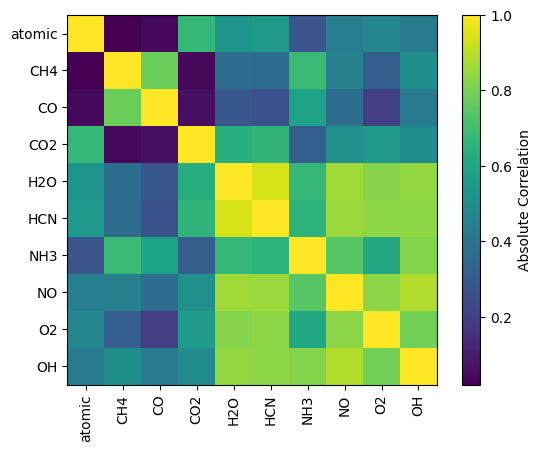

In [13]:
data = []
species = ['atomic', 'CH4', 'CO', 'CO2', 'H2O', 'HCN','NH3', 'NO', 'O2', 'OH']
for i, row in df.iterrows():
    fluxes = []
    for specie in species:
        fluxes.append(total_flux(row[f'FLiTs {specie} Wavelength'], row[f'FLiTs {specie} Flux']))
    data.append(fluxes)
df_FLiTs_flux = pd.DataFrame(data, columns=species)
print(df_FLiTs_flux.corr(method='kendall').round(2))
plt.imshow(abs(df_FLiTs_flux.corr(method='kendall')), cmap=plt.get_cmap("viridis")) # method='kendall'
plt.xticks(ticks=np.arange(len(species)), labels=species, rotation=90)
plt.yticks(ticks=np.arange(len(species)), labels=species)
plt.colorbar(label='Absolute Correlation')
plt.show()

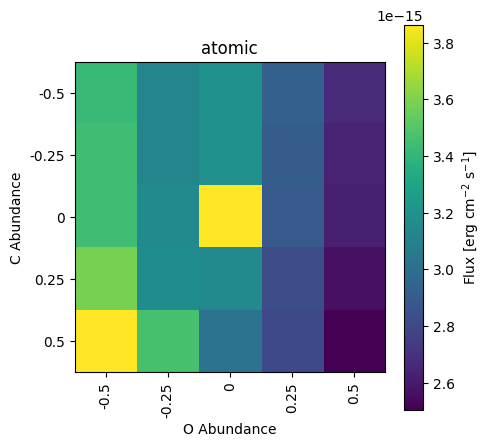

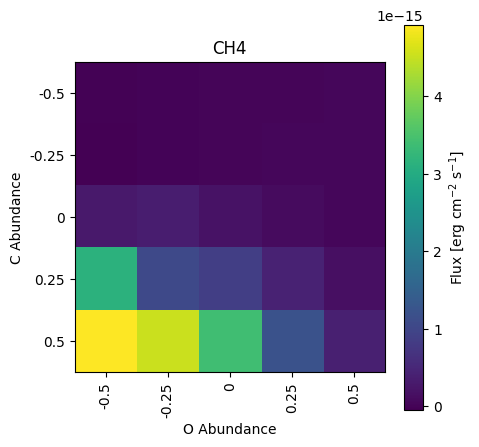

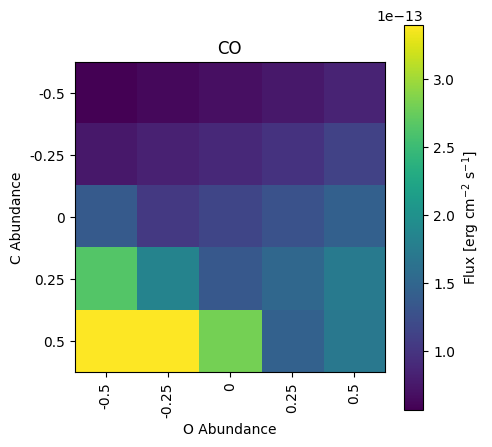

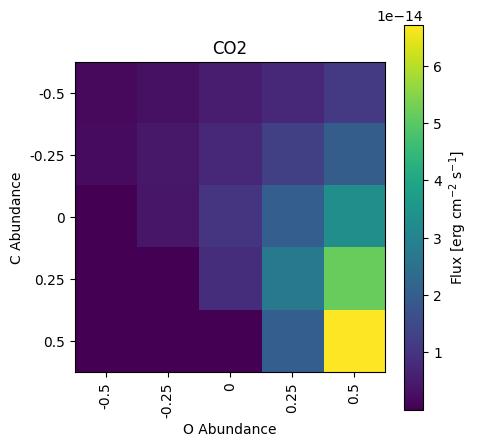

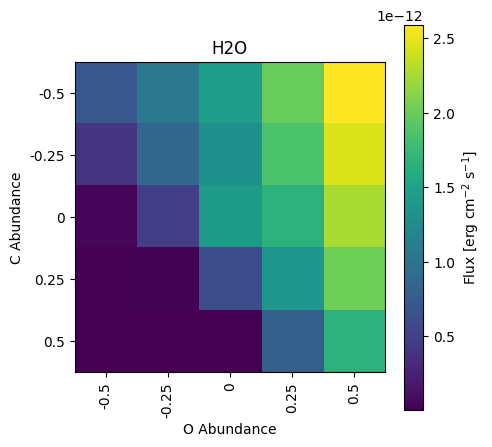

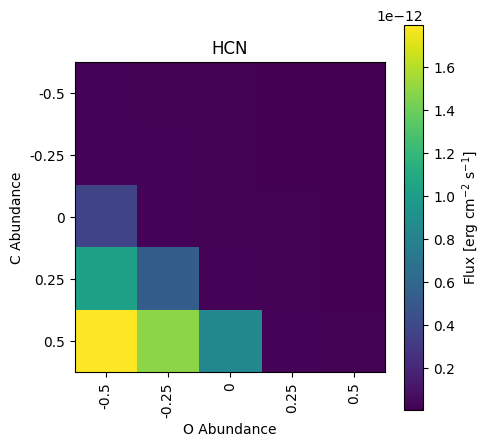

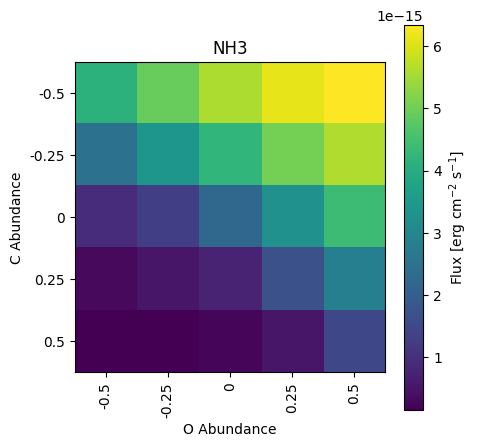

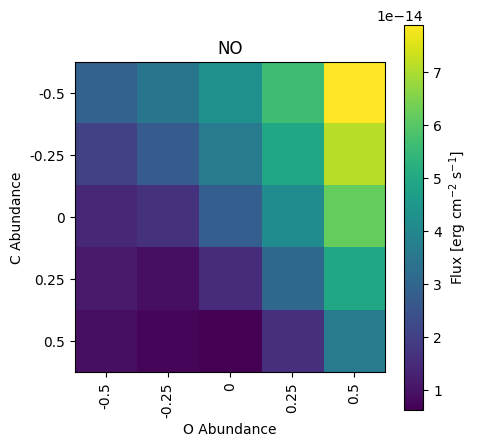

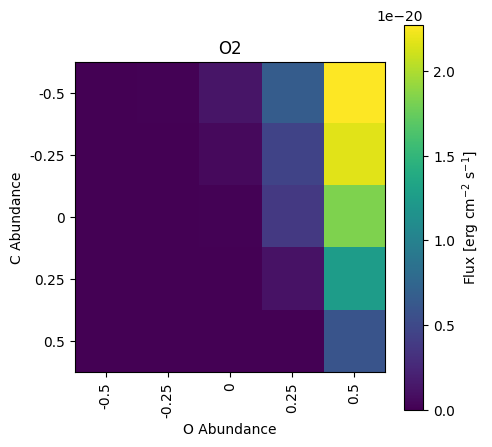

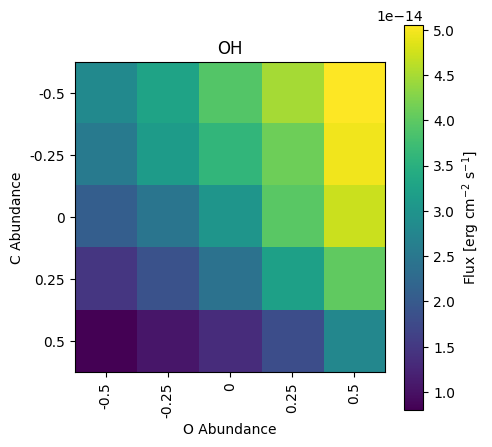

In [14]:

for specie in species:
    plt.figure(figsize=(5, 5))
    plt.imshow(df_FLiTs_flux[specie].values.reshape(5,5), cmap='viridis')
    plt.title(specie)
    plt.xticks(ticks=np.arange(5), labels=[-0.5, -0.25, 0, 0.25, 0.5], rotation=90)
    plt.yticks(ticks=np.arange(5), labels=[-0.5, -0.25, 0, 0.25, 0.5])
    plt.xlabel('O Abundance')
    plt.ylabel('C Abundance')
    plt.colorbar(label='Flux [erg cm$^{-2}$ s$^{-1}$]')
    # plt.savefig(f'Flux_{specie}.png')
    plt.show()